In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# torch.cuda.is_available()
# device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
# torch.cuda.set_device(device)
# torch.set_default_device(device)
device="cpu"

## Load results

In [3]:
true_counts = torch.load("../images/setting2_true_counts.pt").to(device)
true_fluxes = torch.load("../images/setting2_true_fluxes.pt").to(device)
true_locs = torch.load("../images/setting2_true_locs.pt").to(device)
true_total_intensities = torch.load("../images/setting2_true_total_intensities.pt").to(device)
images = torch.load("../images/setting2_images.pt").to(device)
true_total_observed_flux = (images - 19200).sum([1,2])

N0 = 20000
kernel_num_iters = 100
catalogs_per_block = 300
setting2_std_posterior_mean_count = torch.load("./setting2_std_posterior_mean_count.pt", map_location=torch.device('cpu')).to(device)
setting2_std_posterior_mean_total_flux = torch.load("./setting2_std_posterior_mean_total_flux.pt", map_location=torch.device('cpu')).to(device)
setting2_std_log_normalizing_constant = torch.load("./setting2_std_log_normalizing_constant.pt", map_location=torch.device('cpu')).to(device)
setting2_std_runtime = torch.load("./setting2_std_runtime.pt", map_location=torch.device('cpu')).to(device)
setting2_std_num_iters = torch.load("./setting2_std_num_iters.pt", map_location=torch.device('cpu')).to(device)

wastefree_M = 125
setting2_wf_posterior_mean_count = torch.load("./setting2_wf_posterior_mean_count.pt", map_location=torch.device('cpu')).to(device)
setting2_wf_posterior_mean_total_flux = torch.load("./setting2_wf_posterior_mean_total_flux.pt", map_location=torch.device('cpu')).to(device)
setting2_wf_log_normalizing_constant = torch.load("./setting2_wf_log_normalizing_constant.pt", map_location=torch.device('cpu')).to(device)
setting2_wf_runtime = torch.load("./setting2_wf_runtime.pt", map_location=torch.device('cpu')).to(device)
setting2_wf_num_iters = torch.load("./setting2_wf_num_iters.pt", map_location=torch.device('cpu')).to(device)

## Standard results

In [4]:
print(f"RMSE (source count) across {images.shape[0]} images:", ((setting2_std_posterior_mean_count - true_counts)**2).mean().sqrt().item())
print(f"MAE (source count) across {images.shape[0]} images:", ((setting2_std_posterior_mean_count - true_counts).abs()).mean().item())
print(f"RMSE (total flux) across {images.shape[0]} images:", ((setting2_std_posterior_mean_total_flux - true_total_observed_flux)**2).mean().sqrt().item())
print(f"MAE (total flux) across {images.shape[0]} images:", ((setting2_std_posterior_mean_total_flux - true_total_observed_flux).abs()).mean().item())
print(f"correct number of sources detected in {(setting2_std_posterior_mean_count.round() == true_counts).sum()} of the {images.shape[0]} images (accuracy = {(setting2_std_posterior_mean_count.round() == true_counts).sum()/images.shape[0]})")
print(f"number of iterations: mean = {setting2_std_num_iters.mean().int()}, minimum = {setting2_std_num_iters.min().int()}, median = {setting2_std_num_iters.median().int()}, maximum = {setting2_std_num_iters.max().int()}")
print(f"runtime: mean = {setting2_std_runtime.mean().int()}, minimum = {setting2_std_runtime.min().int()}, median = {setting2_std_runtime.median().int()}, maximum = {setting2_std_runtime.max().int()}")

RMSE (source count) across 1000 images: 0.3703225553035736
MAE (source count) across 1000 images: 0.1901659369468689
RMSE (total flux) across 1000 images: 1486.6439208984375
MAE (total flux) across 1000 images: 1138.0714111328125
correct number of sources detected in 838 of the 1000 images (accuracy = 0.8379999995231628)
number of iterations: mean = 46, minimum = 32, median = 42, maximum = 174
runtime: mean = 22, minimum = 15, median = 19, maximum = 82


## Waste-free results

In [5]:
print(f"RMSE (source count) across {images.shape[0]} images:", ((setting2_wf_posterior_mean_count - true_counts)**2).mean().sqrt().item())
print(f"MAE (source count) across {images.shape[0]} images:", ((setting2_wf_posterior_mean_count - true_counts).abs()).mean().item())
print(f"RMSE (total flux) across {images.shape[0]} images:", ((setting2_wf_posterior_mean_total_flux - true_total_observed_flux)**2).mean().sqrt().item())
print(f"MAE (total flux) across {images.shape[0]} images:", ((setting2_wf_posterior_mean_total_flux - true_total_observed_flux).abs()).mean().item())
print(f"correct number of sources detected in {(setting2_wf_posterior_mean_count.round() == true_counts).sum()} of the {images.shape[0]} images (accuracy = {(setting2_wf_posterior_mean_count.round() == true_counts).sum()/images.shape[0]})")
print(f"number of iterations: mean = {setting2_wf_num_iters.mean().int()}, minimum = {setting2_wf_num_iters.min().int()}, median = {setting2_wf_num_iters.median().int()}, maximum = {setting2_wf_num_iters.max().int()}")
print(f"runtime: mean = {setting2_wf_runtime.mean().int()}, minimum = {setting2_wf_runtime.min().int()}, median = {setting2_wf_runtime.median().int()}, maximum = {setting2_wf_runtime.max().int()}")

RMSE (source count) across 1000 images: 0.39367908239364624
MAE (source count) across 1000 images: 0.2064833790063858
RMSE (total flux) across 1000 images: 1621.427490234375
MAE (total flux) across 1000 images: 1252.8985595703125
correct number of sources detected in 815 of the 1000 images (accuracy = 0.8149999976158142)
number of iterations: mean = 48, minimum = 32, median = 42, maximum = 177
runtime: mean = 48, minimum = 32, median = 42, maximum = 175


## Plots

In [55]:
max_objects = 9

wf_num_correct_by_count = torch.zeros(max_objects)
wf_prop_correct_by_count = torch.zeros(max_objects)
std_num_correct_by_count = torch.zeros(max_objects)
std_prop_correct_by_count = torch.zeros(max_objects)
wf_mean_estimated_count_by_count = torch.zeros(max_objects)
std_mean_estimated_count_by_count = torch.zeros(max_objects)
wf_mae_by_count =  torch.zeros(max_objects)
std_mae_by_count =  torch.zeros(max_objects)

for num in range(max_objects):
    wf_num_correct_by_count[num] = (setting2_wf_posterior_mean_count[true_counts==num].round() == true_counts[true_counts==num]).sum()
    wf_prop_correct_by_count[num] = wf_num_correct_by_count[num]/(true_counts==num).sum()
    
    std_num_correct_by_count[num] = (setting2_std_posterior_mean_count[true_counts==num].round() == true_counts[true_counts==num]).sum()
    std_prop_correct_by_count[num] = std_num_correct_by_count[num]/(true_counts==num).sum()
    
    
    wf_mean_estimated_count_by_count[num] = setting2_wf_posterior_mean_count[true_counts==num].mean()
    std_mean_estimated_count_by_count[num] = setting2_std_posterior_mean_count[true_counts==num].mean()
    
    wf_mae_by_count[num] = ((setting2_wf_posterior_mean_count[true_counts==num] - true_counts[true_counts==num]).abs()).mean()
    std_mae_by_count[num] = ((setting2_std_posterior_mean_count[true_counts==num] - true_counts[true_counts==num]).abs()).mean()
    
    
    
    

In [43]:
#true_total_observed_flux.shape #true total flux for each image 

setting2_std_posterior_mean_total_flux.shape #same idea?? 

torch.Size([1000])

In [49]:
import numpy as np

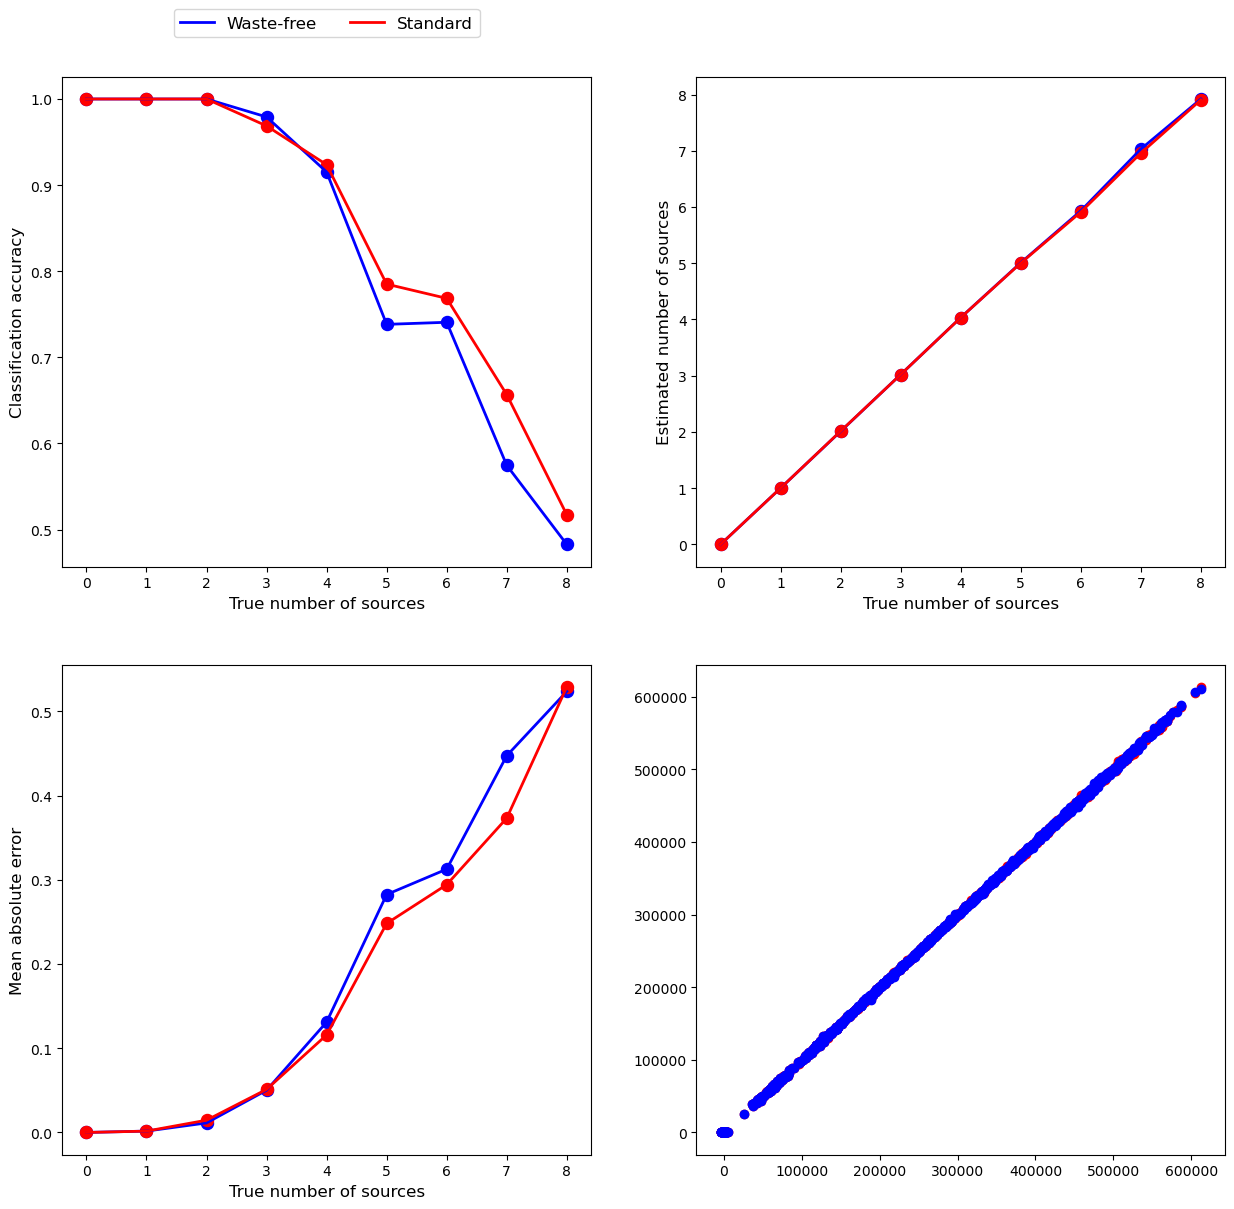

In [57]:
dot_size = 75
line_width = 2
text_size = 12

wf_color = "blue"
std_color = "red"

range_max_objects = torch.arange(max_objects, device="cpu")

fig2, [[fig2a,fig2b],[fig2c,fig2d]] = plt.subplots(nrows = 2, ncols = 2, figsize = (15,14))

fig2a.plot(range_max_objects, wf_prop_correct_by_count.cpu(), label = "Waste-free", color = "blue", linewidth = line_width)
fig2a.scatter(range_max_objects, wf_prop_correct_by_count.cpu(), color = "blue", s = dot_size)

fig2a.plot(range_max_objects, std_prop_correct_by_count.cpu(), label = "Standard", color = "red", linewidth = line_width)
fig2a.scatter(range_max_objects, std_prop_correct_by_count.cpu(), color = "red", s = dot_size)

fig2a.set_xlabel("True number of sources", fontsize = text_size)
fig2a.set_ylabel("Classification accuracy", fontsize = text_size)
fig2a.legend(ncol=2, fancybox=True, loc="upper center", bbox_to_anchor=(0.5,1.155), fontsize = text_size)



fig2b.plot(range_max_objects, wf_mean_estimated_count_by_count.cpu(), color = wf_color, label = "Waste-free", linewidth = line_width)
fig2b.scatter(range_max_objects, wf_mean_estimated_count_by_count.cpu(), color = wf_color, s = dot_size)

fig2b.plot(range_max_objects, std_mean_estimated_count_by_count.cpu(), color = std_color, label = "Standard", linewidth = line_width)
fig2b.scatter(range_max_objects, std_mean_estimated_count_by_count.cpu(), color = std_color, s = dot_size)
fig2b.set_xlabel("True number of sources", fontsize = text_size)
fig2b.set_ylabel("Estimated number of sources", fontsize = text_size)


fig2c.plot(range_max_objects, (wf_mae_by_count + wf_mae_by_count[0]).cpu(), label = "Waste-free", color = wf_color, linewidth = line_width)
fig2c.scatter(range_max_objects, wf_mae_by_count.cpu(), color = wf_color, s = dot_size)

fig2c.plot(range_max_objects, (std_mae_by_count + std_mae_by_count[0]).cpu(), label = "Standard", color = std_color, linewidth = line_width)
fig2c.scatter(range_max_objects, std_mae_by_count.cpu(), color = std_color, s = dot_size)
fig2c.set_xlabel("True number of sources", fontsize = text_size)
fig2c.set_ylabel("Mean absolute error", fontsize = text_size)

fig2d.scatter(true_total_observed_flux, setting2_std_posterior_mean_total_flux,color = std_color)
fig2d.scatter(true_total_observed_flux, setting2_wf_posterior_mean_total_flux,color = wf_color)
#how does this one work? 


In [54]:
np.where(true_total_observed_flux == 0)

(array([], dtype=int64),)